Model Name: all-mpnet-base-v2 

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('../CSV/Data/preped_data.csv')

labels = pd.read_csv('../CSV/Data/labels.csv')

In [4]:
data.shape

(9494, 12)

In [5]:
labels.shape

(220, 1)

In [6]:
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

In [ ]:
#15 min
data['d_embedding'] = data['description'].apply(lambda x: model.encode(x, convert_to_tensor=True)if isinstance(x, str) else None)
data['b_embedding'] = data['business_tags'].apply(lambda x: model.encode(x, convert_to_tensor=True) if isinstance(x, str) else None)

In [ ]:
labels['l_embedding'] = labels['label'].apply(lambda x: model.encode(x, convert_to_tensor=True) if isinstance(x, str) else None)

In [9]:
description_similarity = []
business_tags_similarity = []

In [ ]:
for i in range(data.shape[0]):
    if data['d_embedding'][i] is not None:
        description_similarity.append(cosine_similarity([data['d_embedding'][i]], labels['l_embedding'].tolist())[0])
    else:
        description_similarity.append([0] * len(labels))
    if data['b_embedding'][i] is not None:
        business_tags_similarity.append(cosine_similarity([data['b_embedding'][i]], labels['l_embedding'].tolist())[0])
    else:
        business_tags_similarity.append([0] * len(labels))

In [12]:
similarities = (np.array(description_similarity) + np.array(business_tags_similarity)) / 2

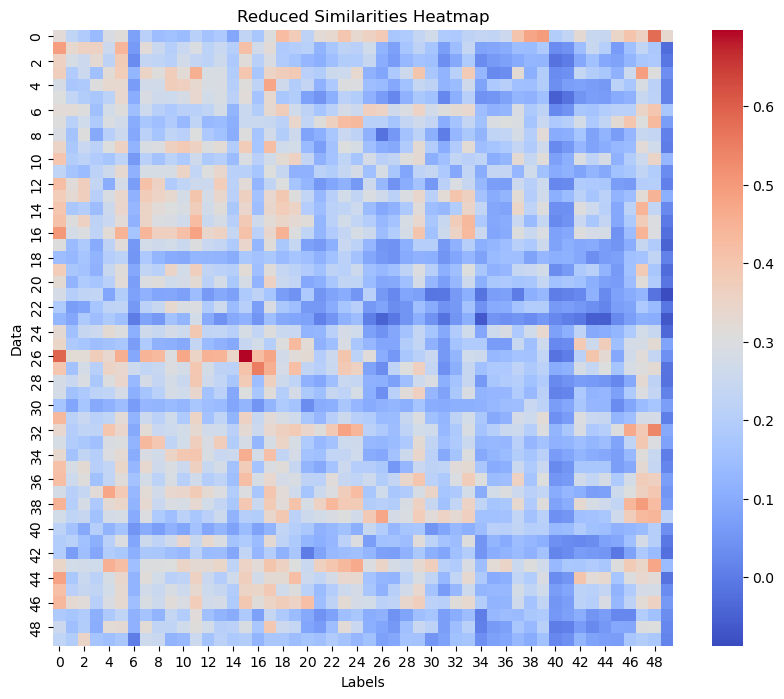

In [17]:
reduced_similarities = similarities[:50, :50] 

plt.figure(figsize=(10, 8))
sns.heatmap(reduced_similarities, cmap='coolwarm', cbar=True)
plt.title("Reduced Similarities Heatmap")
plt.xlabel("Labels")
plt.ylabel("Data")
plt.show()

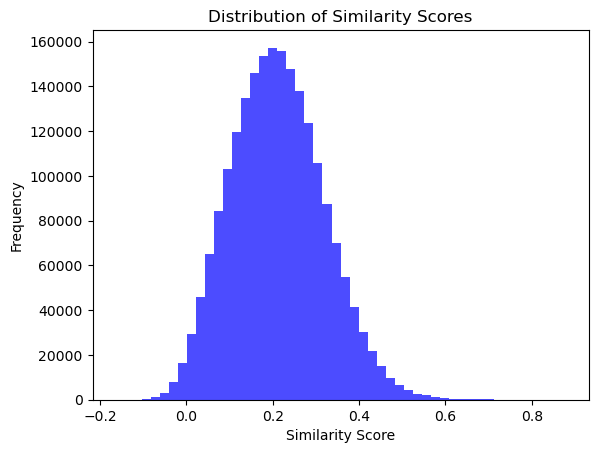

In [20]:
flattened_similarities = similarities.flatten()
plt.hist(flattened_similarities, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()

In [ ]:
def get_top_labels(similarities, labels, top_n=3):
    top_indices = np.argsort(similarities, axis=1)[:, -top_n:][:, ::-1]
    top_labels_with_scores = [[(labels[i], similarities[row_idx, i]) for i in indices] for row_idx, indices in enumerate(top_indices)]
    return top_labels_with_scores

In [21]:
similarities_array = np.vstack(similarities[:data.shape[0]])

In [22]:
data['top_labels'] = get_top_labels(similarities_array, labels['label'].tolist(), top_n=3)

In [ ]:
data[['description', 'business_tags', 'top_labels']].to_csv('../CSV/Tries/labelled_data_sbert1.csv', index=False)